# [IAPR 2019:][iapr2019] Lab 1 ‒  Image segmentation

**Author:** Raphaël Reis Nunes, Oriane Peter  
**Due date:** 04.04.2019

[iapr2019]: https://github.com/LTS5/iapr-2019

## Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import numpy as np
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Part 1: Brain segmentation

Your goal: compute the size of the brain (in pixels) in a 2D image of a human head taken by Magnetic Resonance Imaging (MRI).
* Try as many methods as you can, the more the better.
* At least region growing and contour detection.

### 1.0 Brain image visualization

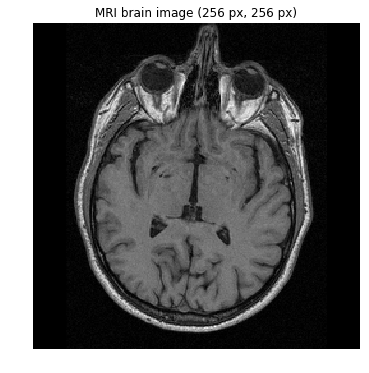

In [2]:
import skimage.io 
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

### 1.1 Package imports and General observation

In [3]:
#Necessary packages to run the notebook
import numpy as np
import scipy.ndimage as ndimage
from skimage import data
from skimage import filters
from skimage import exposure
from skimage import measure
from skimage.filters import sobel, threshold_otsu
from skimage.morphology import watershed
from skimage.segmentation import flood_fill
from skimage.measure import label
from skimage.color import rgb2hsv
from skimage.color import rgb2gray

#Plot standard
import matplotlib as mpl
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['figure.figsize'] = (15, 8)

mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 14

#Method used for contour detection
def largest_contour_index(contours):
    '''Takes a list of countours and return the largest contour'''
    contours_ = np.array(contours)
    max_size = 0
    max_ind = 0
    for index, contour in enumerate(contours_):
        size = contour.size
        if size > max_size:
            max_size = size
            max_ind = index
    return max_ind


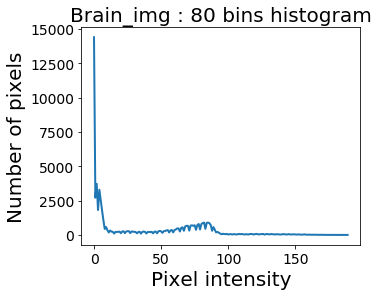

In [4]:
#Let's discover image distribution
nb_bins = 80

##Displays histogram
camera = brain_im
hist, bins_center = exposure.histogram(camera)
fig = plt.figure(figsize=(5, 4))
plt.plot(bins_center, hist, lw=2)
plt.xlabel('Pixel intensity')
plt.ylabel('Number of pixels')
plt.title('Brain_img : {} bins histogram'.format(nb_bins))

plt.show()



#### Discussion:
At first glance, histogram says that most of pixels are black and the other are gray-dark. Looking at the brain_im file we can say that big spike corresponds to the background. The skull image is spred in pixel intensity between 50 and 100.

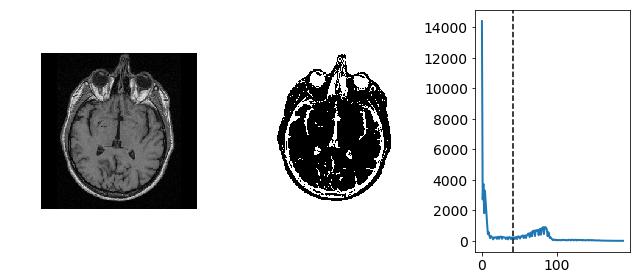

In [5]:
#Thanks to otsu threshold automatic detection we manage to find optimal threshold.

val = filters.threshold_otsu(brain_im)

hist, bins_center = exposure.histogram(brain_im)

plt.figure(figsize=(9, 4))
plt.subplot(131)
plt.imshow(brain_im, cmap='gray', interpolation='nearest')
plt.axis('off')
plt.subplot(132)
plt.imshow(brain_im < val, cmap='gray', interpolation='nearest')
plt.axis('off')
plt.subplot(133)
plt.plot(bins_center, hist, lw=2)
plt.axvline(val, color='k', ls='--')

plt.tight_layout()
plt.show()

#### Discussion:
As predicted above, threshold that split foreground from background find that relevent information lies above 50 of intensity.

### 1.2 Region growing
Add your implementation and discussion

Following: 
           - http://scikit-image.org/docs/dev/user_guide/tutorial_segmentation.html
           - http://scikit-image.org/docs/dev/auto_examples/segmentation/plot_floodfill.html

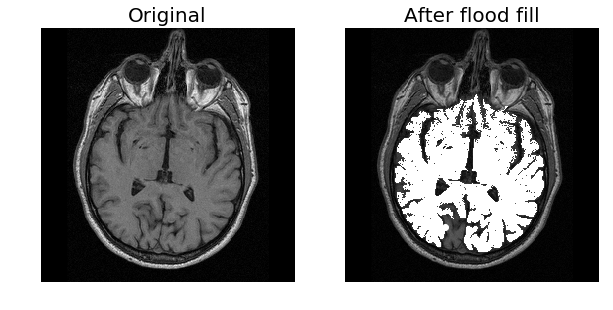

In [6]:
#Use a pixel in the brain to switch all pixel with tolerance 15 to 255 insensity.
point_in_brain = (100,100)
color_switch = 255
light_brain = flood_fill(brain_im, point_in_brain, color_switch, tolerance=15)

fig, ax = plt.subplots(ncols=2, figsize=(10, 5))

ax[0].imshow(brain_im, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].imshow(light_brain, cmap=plt.cm.gray)
ax[1].plot(100, 200, 'wo')  # seed point
ax[1].set_title('After flood fill')
ax[1].axis('off')

plt.show()

In [7]:
pix_size = int(light_brain[light_brain==255].sum()/255)
print('Size in pixels of the brain captured by flod_fill: {} pixels'.format(pix_size))

Size in pixels of the brain captured by flod_fill: 13881 pixels


#### Discussion

In the figure above, we see by comparison with the original image that flood_fill is quite precise regarding the shape of the brain contour of the brain.
However, it's not able to capture the down left part which is easy to spot. May be due to strong edges that prevent algorithm to get in this part

### 1.3 Contour detection
Add your implementation and discussion

In [8]:
copy = brain_im.copy()
copy2 = brain_im.copy()
#Trick to allow algorithm to differenciate contour from external part of skull and internal part.
#  => Set a black line to cut the brain from the external part
copy[82, 150:170] = 0

# Find contours at a constant value of 55
contours = measure.find_contours(copy, 55, 'high')
contours_normal = measure.find_contours(copy2, 55, 'high')

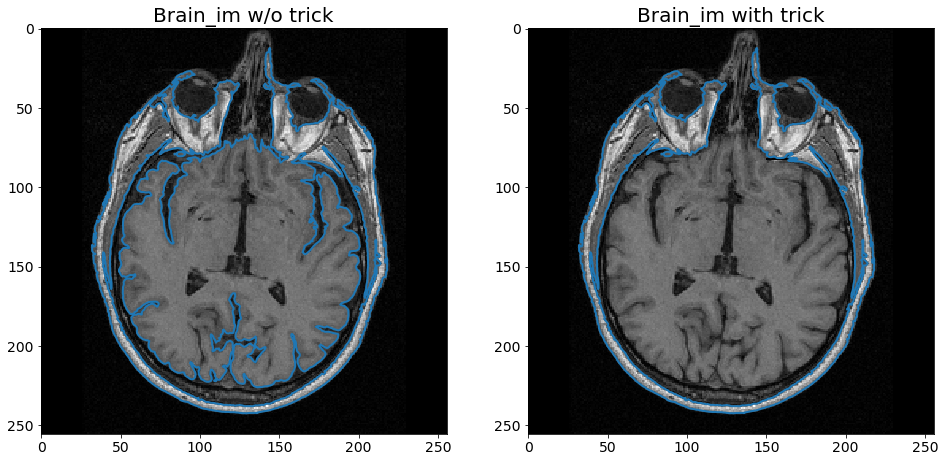

In [9]:
# Display the image and plot for largest contour
fig, ax = plt.subplots(1, 2, figsize=(16,8))

ax[0].imshow(copy2, interpolation='nearest', cmap='gray')
ax[1].imshow(copy, interpolation='nearest', cmap='gray')


ind_largest_cont = largest_contour_index(contours)
ind_largest_cont_normal = largest_contour_index(contours_normal)

ax[0].plot(np.array(contours_normal)[ind_largest_cont_normal][:, 1],
           np.array(contours_normal)[ind_largest_cont_normal][:, 0], linewidth=2)
ax[1].plot(np.array(contours)[ind_largest_cont][:, 1], np.array(contours)[ind_largest_cont][:, 0], linewidth=2)

ax[0].set_title('Brain_im w/o trick')
ax[1].set_title('Brain_im with trick')

plt.show()

#### Discussion

We can see that the contour takes both the brain and the external part. A trick (see comments in the code) is used to prevent this and only get contour of the external part 

In [10]:
#Lets create an mask that will be used to remove external part of the image and isolate th brain

# Create an empty image to store the masked array
extern_mask = np.zeros_like(copy, dtype='bool')

# Create a contour image by using the contour coordinates rounded to their nearest integer value
extern_mask[np.round(contours[ind_largest_cont][:, 0]).astype('int'), np.round(contours[ind_largest_cont][:, 1]).astype('int')] = 1

# Fill in the hole created by the contour boundary
extern_mask = ndimage.binary_fill_holes(extern_mask)

# Invert the mask since you want pixels outside of the region
#r_mask = ~r_mask

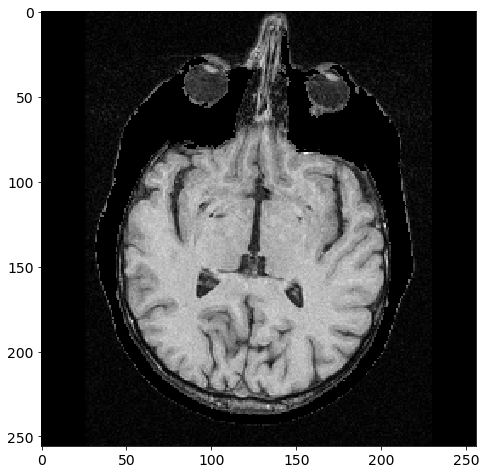

In [11]:
#Set all values within the mask to 0
copy[extern_mask] = 0
plt.imshow(copy, cmap='gray')
plt.show()

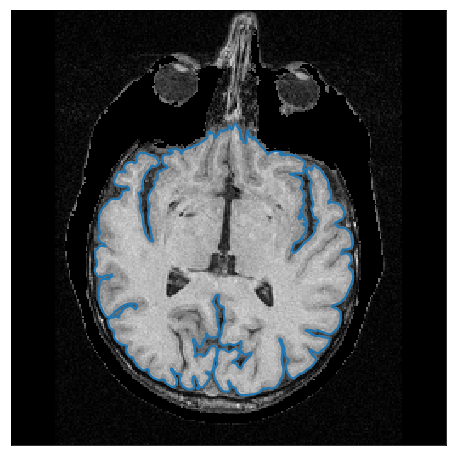

In [12]:
#Now applying the find contours method allows to get the contour of the brain only.
brain_contours = measure.find_contours(copy, 55, 'high')

fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(8)
ax.imshow(copy, interpolation='nearest', cmap='gray')


ind_largest_cont = largest_contour_index(brain_contours)
ax.plot(np.array(brain_contours)[ind_largest_cont][:, 1],
        np.array(brain_contours)[ind_largest_cont][:, 0], linewidth=2)


import scipy.ndimage as ndimage    

# ax.plot(contour[:, 1], contour[:, 0], linewidth=2)
ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [13]:
#Lets create a final mask which allows to remove everything but the brain
# Create an empty image to store the masked array
b_mask = np.zeros_like(copy, dtype='bool')

# Create a contour image by using the contour coordinates rounded to their nearest integer value
b_mask[np.round(brain_contours[ind_largest_cont][:, 0]).astype('int'), 
       np.round(brain_contours[ind_largest_cont][:, 1]).astype('int')] = 1

# Fill in the hole created by the contour boundary
b_mask = ndimage.binary_fill_holes(b_mask)



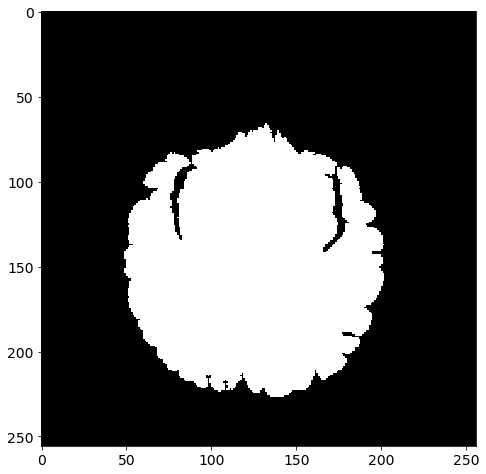

In [14]:
copy[b_mask] = 255
copy[copy != 255] = 0
plt.imshow(copy, cmap='gray')
plt.show()

In [15]:
pixels_size = copy[copy == 255].sum()/255
print('Size in pixels of the brain captured by flod_fill: {} pixels'.format(pixels_size))

Size in pixels of the brain captured by flod_fill: 17957.0 pixels


#### Discussion
Here the external shape is better than the previous method since we managed to encapture all the parts of the brain. However, we are not able here remove internal empty parts. May be with more hyperparameters finetuning.

The brain size in pixels is coherent with the previous method result. Indeed, previously we get 138881 pxs but had less external part of the brain and removed empty space inside. Which is consistant with a 17957-13881 = 4070 pixs difference.

### 1.4 Additional method(s)
Add your implementation and discussion

Credits to skimage tutorials

### 1.4.1 First additional method 

Text(0.5, 1.0, 'elevation_map')

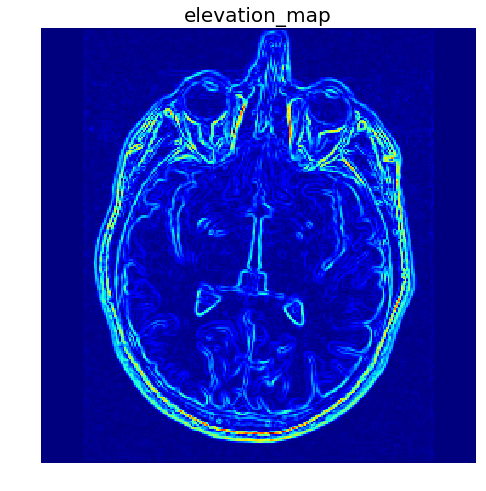

In [16]:
#Get the elevation map of the brain_im
elevation_map = sobel(brain_im)

plt.figure()
plt.imshow(elevation_map, cmap='jet', interpolation='nearest')
plt.axis('off')
plt.title('elevation_map')

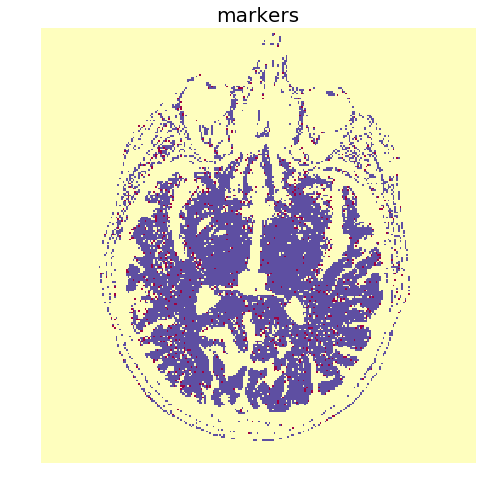

In [17]:
#The g oal is to attribute labels to specific range of intensity
markers = np.zeros_like(brain_im)

###Best solution so far
min_thres = 69
max_thres = 90
markers[brain_im < min_thres] = 1
markers[brain_im > max_thres] = 1
markers[(brain_im > min_thres) & (brain_im < max_thres)] = 2
#####

###Second best solution
# markers[brain_im < 45] = 1
# markers[brain_im > 90] = 1
# markers[(brain_im > 55) & (brain_im < 90)] = 2
###

plt.figure()
plt.imshow(markers, cmap='Spectral', interpolation='nearest')
plt.axis('off')
plt.title('markers')
plt.show()

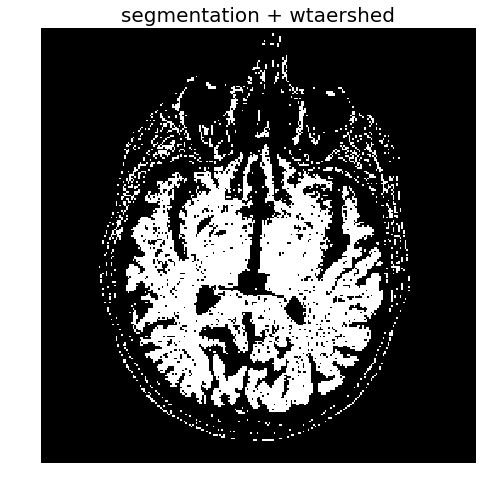

In [18]:
#Get segmentation of brain_im
segmentation = watershed(elevation_map, markers)

plt.figure()
plt.imshow(segmentation, cmap='gray', interpolation='nearest')
plt.axis('off')
plt.title('segmentation + wtaershed')
plt.show()

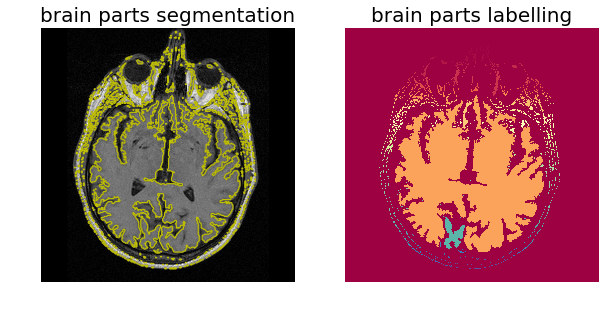

In [19]:
#Thanks to binary_fill_holes we are able to label each part of the brain.
segmentation = ndimage.binary_fill_holes(segmentation - 1)
labeled_brain, _ = ndimage.label(segmentation)

plt.figure(figsize=(10,6))
plt.subplot(121)
plt.imshow(brain_im, cmap='gray', interpolation='nearest')
plt.contour(segmentation, [0.5], linewidths=1.2, colors='y')
plt.axis('off')
plt.title('brain parts segmentation')
plt.subplot(122)
plt.imshow(labeled_brain, cmap='Spectral', interpolation='nearest')
plt.axis('off')
plt.title('brain parts labelling')
plt.show()

In [20]:
brain_label = labeled_brain[150, 100]

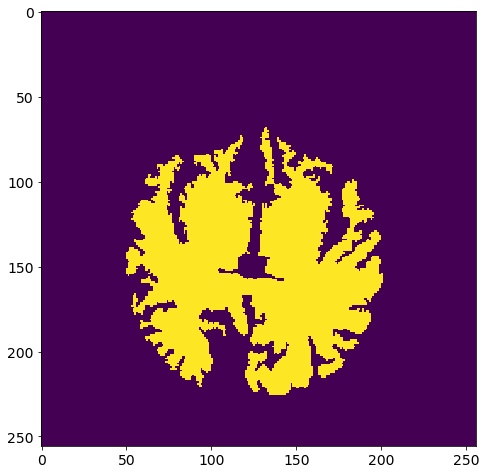

In [36]:
brain = (labeled_brain == brain_label)
plt.imshow(brain)
plt.show()

In [22]:
brain_size_pixels = np.sum(brain)

In [23]:

pixels_size_last = np.sum(brain)
print('Size in pixels of the brain captured by flod_fill: {} pixels'.format(pixels_size_last))

Size in pixels of the brain captured by flod_fill: 12880 pixels


#### Discussion
Brain is much more shrinked but this time we got part of intern holes. However like in first method, we lost the little down left part of the brain

### 1.4.2 Second additional method

Size of the brain, approximated as the number of pixels in the labbeled brain region:  15881.
Size of the brain, approximated as a disk with diameter equal to width of the bounding box:  17898.


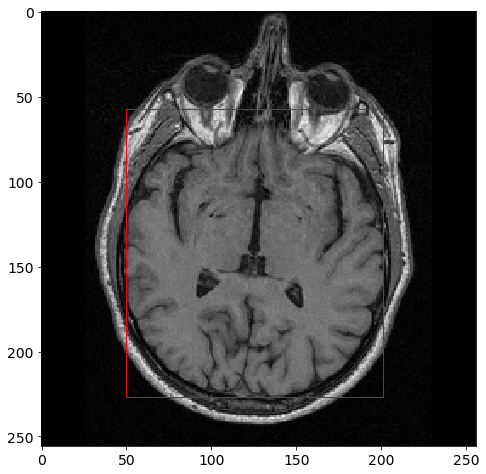

In [24]:
from skimage.filters import threshold_otsu
from skimage.morphology import binary_erosion,closing,disk
from skimage.measure import label,regionprops

#Remove the background 
thresh = threshold_otsu(brain_im)
noBackGround_img = (brain_im < thresh)

# Find the skull and remove it to isolate the brain
around = (brain_im < 90)
around = around.astype(np.int32)
noBackGround_img = noBackGround_img.astype(np.int32)
brain = noBackGround_img-around

#Connect the brain and remove the small black holes to use labeling  
brain_err=binary_erosion(brain)
brain_err=binary_erosion(brain)
new_brain = closing(brain_err,disk(2))

#Labbeling 
label_image = label(new_brain)
proprieties = regionprops(label_image)

#Get max area by assuming the biggest region is the brain
area = [prop.area for prop in proprieties ]
max_area =[prop for prop in proprieties if (prop.area == max(area)) ]
max_area = max_area[0]

#Draw bbox to check previous assumption 
fig, ax = plt.subplots()
rect = patches.Rectangle((max_area.bbox[1], max_area.bbox[0]), max_area.bbox[3]-max_area.bbox[1], max_area.bbox[2]-max_area.bbox[0],
                linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
ax.imshow(brain_im,cmap=plt.cm.gray)

#Calcualte the brain size by taking the number of pixel of the labbeled brain region 
Size_brain_1 = max_area.area
print("Size of the brain, approximated as the number of pixels in the labbeled brain region:  %d." % (Size_brain_1))

#Calculate the brain size based on observation that radius is approximatively half or the lenght
brain_size_2 = 3.14* ((max_area.bbox[3]-max_area.bbox[1])/2)*((max_area.bbox[3]-max_area.bbox[1])/2)
print("Size of the brain, approximated as a disk with diameter equal to width of the bounding box:  %d." % (brain_size_2))



#### Discussion:

Using errosion is useful to isolate the brain region before the labbeling. We can see from the bounding box that the biggest labeling region indeed corresponds to the brain. The folding of the brain leaves dark spots too big to remove using closing. Those spots are therefore not included in the labbeled region. This is confirmed by calculating the size by approximating the brain by a disk of the diameter equal to the width of the bounding box. Doing this calculates a significently bigger brain' size that by counting the number of pixel in the labbeled area.

### Final conclusions:

With those numerous methods, me managed to have a range of pixels between 12880 and 17957 calculating the size of the brain. The quality of the results depends a lot on what is considered as a good shaping of the brain (tradeoff between easy implementation, fast computation, precision of the countours detection, importance of letting holes out of calculations, etc ...).  All of this taken into account, we could say: 
    * Region growing thanks to watershedding is very simple to implement and take into account the holes inside the brain
    * Contour detection make a very precise job on finding the right path to fit the brain frontiers but asks some hand tricks that could be tedious on a daily routine. Moreover, it does not detect intern holes.
    * Elevation map with region labelling do the job but the computation is quite more costly than other methods and the result looks like a desiccated nut (may be to much shrinkage in the algroithm).
    * Bounding box with the help of erosion seems to be one of the most accurate method.

## Part 2: Save the bees !

Varroa mites are recognized as the biggest pest to honey bees worldwide, and are believed to be the single largest contributing factor in the modern-day decline of honey bees due to their ability to transmit diseases, resulting in death or severe deformity of the pupae. 

Detecting and quantifying the presence of Verroa in a beehive is therefore crucial to treat the infection appropriately and as early as possible, and image analysis appears very useful in this problem.

![Varroa Mite](https://lts5www.epfl.ch/wp-content/uploads/2018/07/varroa-2.jpg)



### 2.1 Introduction to Project

You will find hereafter a set of 4 images taken under real conditions. In this task you will be ask to:
1. Count the number of Varroa on each picture
2. Determine the Intersection over Union of the detected patterns w.r.t. the ground truth
3. Estimate the Precision, Recall and F1-score at two different IoU thresholds $T = {0.5 \text{, and } 0.9}$


**Note** 

Try to have the same routine(s) running on the four images, and giving (approximatively) the same results. The routine(s) that you will write for this part will be useful for the final project as well, so pay special attention to it.

#### Vocabulary


* **IoU**: Let $A$ be the ground truth area and $B$ the predicted one. the intersection over union (IoU) is given as:
$$IoU(A,B) = \frac{A \cap B}{A \cup B} = \frac{\text{Area of Overlap}}{\text{Area of Union}}$$
Let $T$ be a scalar in the interval $[0, 1]$, then $B$ will be considered as a true positive (TP) if and only if $IoU(A,B) \ge T$. As a results, we can evaluate the performance of our detection with different values of $T$. The larger $T$ is, the more constraining is our condition.


* **Precision**: The precision is given as:
$$precision = \frac{tp}{tp + fp}$$
where $tp$ is the number of true positives and $fp$ the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.


* **Recall**: The recall is given as:
$$precision = \frac{tp}{tp + fn}$$
where $tp$ is the number of true positives and $fn$ the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.


* **F1-score**: The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:
$$F1 = \frac{2 \cdot precision \cdot recall}{precision + recall}$$


**FAQ**

Q: What to do if I have multiple ground truth $A_i$ and candidates $B_j$ and want to find the best set $(i,j)$ such that $(i, j) = \arg\max_{i,j} IoU(A_i, B_j)$ ? 

A: Here, we recommend to use a brute force approach. It corresponds to compute $IoU(A, B)$ for every possible pairs (i,j) and keep the pair with the highest $IoU$. Note that a candidate $B_j$ can **only** be matched to **one** ground truth area $A_i$.

Here, we visualize the 4 images for our patern detection

In [25]:
# Load images
im_names = ['varroa-01', 'varroa-02', 'varroa-03', 'varroa-04']
filenames = [os.path.join(data_path, name) + '.jpg' for name in im_names]
ic = skimage.io.imread_collection(filenames)
print('Number of images: ', len(ic))

Number of images:  4


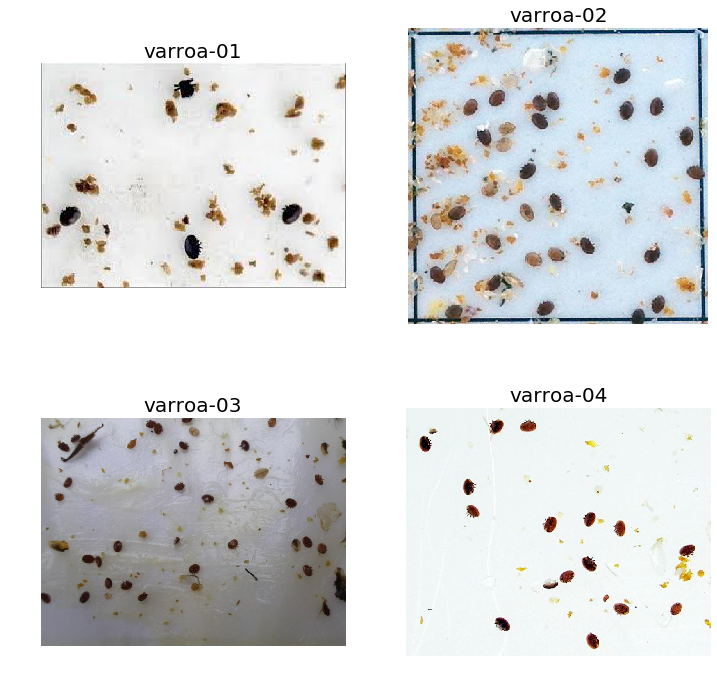

In [26]:
# Plot images
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), ic, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

We can as well add the groud truth label that are stored in the corresponding XML files. Each xml file stores the position of the varroa on the image as :

```xml
<annotation>
	<object>
		<name>Varroa</name>
		<difficult>0</difficult>
		<bndbox>
			<xmin>14</xmin>
			<ymin>117</ymin>
			<xmax>33</xmax>
			<ymax>137</ymax>
		</bndbox>
	</object>
	<object>
		...
	</object>
	...
</annotation>
```
The block `object` defines the attributes of the varroa. `name` is the definition of the object class (always varroa). `bndbox` is the definition of the bounding box. To simplify your task, we implemented a function named `parse_file` that returns an array with the bounding box of the varroa expressed as `(x, y, width, heigth)` which corresponds to `(xmin, ymin, xmax-xmin, ymax-ymin)`

In [27]:
import xml.etree.ElementTree as ET

def parse_file(filename):
    """ Parse a PASCAL VOC xml file """
    tree = ET.parse(filename)
    objects = []
    for obj in tree.findall('object'):
        obj_struct = {}
        obj_struct['name'] = obj.find('name').text
        bbox = obj.find('bndbox')
        obj_struct['bbox'] = [int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymin').text)),
                              int(float(bbox.find('xmax').text))-int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymax').text))-int(float(bbox.find('ymin').text))]
        objects.append(obj_struct)

    return objects

In [28]:
annotations_xmls = [parse_file(os.path.join(data_path, name) + '.xml') for name in im_names]

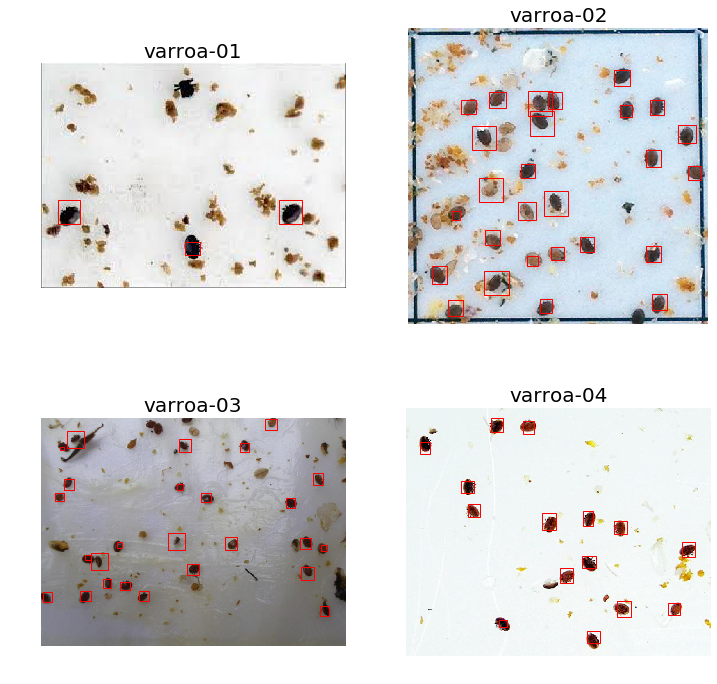

In [29]:
# Plot images
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for ax, im, nm, annotations in zip(axes.ravel(), ic, im_names, annotations_xmls):
    # Iterate over annotations
    for anno in annotations:
        rect = patches.Rectangle((anno['bbox'][0], anno['bbox'][1]), anno['bbox'][2], anno['bbox'][3],
                linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
    
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.2 Count the number of Varroa on each picture

Add your implementation and discussion

Hint: `skimage.measure.label` might be useful to label the thresholded image

In [30]:
def draw_bbox(image,ax):
    """ Finds the Varroas on an image by labbeling, draw a bounding box surrounding them.  """
    """Inputs : The image to analyse, the figure to plot it on
       Output : the labbels that were determined to corresponds to the Varroas."""
    #Remove background
    value_img = rgb2gray(image)
    thresh = threshold_otsu(image)
    
    #Distinguish between two type of objects 
    thresh2 = threshold_otsu(value_img[value_img < thresh])
    binary = (value_img < thresh2)
    
    #Label image
    label_image = label(binary)
    proprieties = regionprops(label_image)
    
    #Keep the label in the correct size range and with an approcimatively squared bbox
    large_label = [prop for prop in proprieties if ((prop.area > 200) and (prop.area < 940)) and 
                   (max(prop.bbox[3]-prop.bbox[1],prop.bbox[2]-prop.bbox[0])/min(prop.bbox[3]-prop.bbox[1],prop.bbox[2]-prop.bbox[0])<2)]
    
    #Draw the box 
    for l in large_label:
        rect = patches.Rectangle((l.bbox[1], l.bbox[0]), l.bbox[3]-l.bbox[1], l.bbox[2]-l.bbox[0],
                linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)

    return large_label

/Users/Raphael/Documents/GitHub/iapr-2019/scikit-image/skimage/filters/thresholding.py:274: UserWarning: threshold_otsu is expected to work correctly only for grayscale images; image shape (193, 261, 3) looks like an RGB image
  warn(msg.format(image.shape))
/Users/Raphael/Documents/GitHub/iapr-2019/scikit-image/skimage/filters/thresholding.py:274: UserWarning: threshold_otsu is expected to work correctly only for grayscale images; image shape (427, 432, 3) looks like an RGB image
  warn(msg.format(image.shape))
/Users/Raphael/Documents/GitHub/iapr-2019/scikit-image/skimage/filters/thresholding.py:274: UserWarning: threshold_otsu is expected to work correctly only for grayscale images; image shape (480, 640, 3) looks like an RGB image
  warn(msg.format(image.shape))
/Users/Raphael/Documents/GitHub/iapr-2019/scikit-image/skimage/filters/thresholding.py:274: UserWarning: threshold_otsu is expected to work correctly only for grayscale images; image shape (622, 763, 3) looks like an RGB im

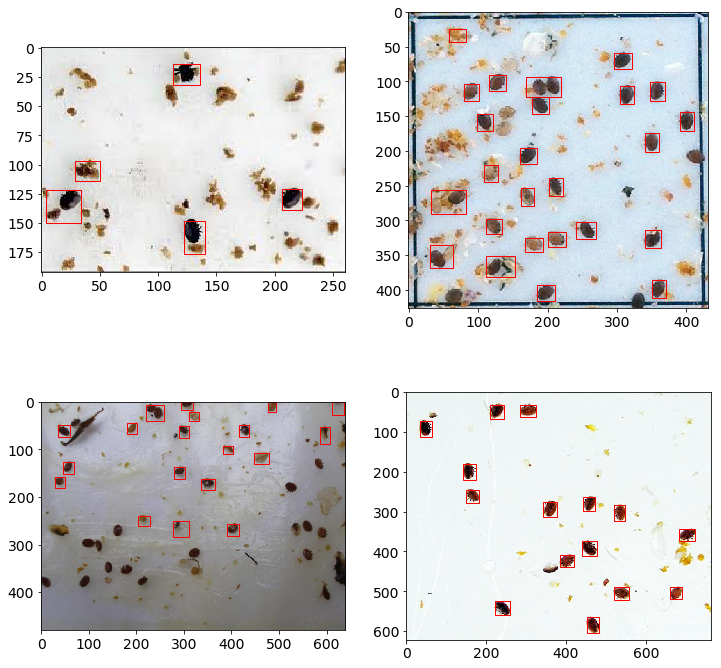

In [31]:
##Nice plotting axe
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

##Finding the Varroas 
flabels = []
for ax, im in zip(axes.ravel(), ic) :
    flabels.append(draw_bbox(im,ax))
    ax.imshow(im)

#### Discussion

Two observations were used to differentiate the varroas from the reste of the image : They are much darker than the rest of the image and have a very similar size in each picture. 

The first observation means it is enought to keep only the values that are low in intensity. This is done through two thresholding steps : a first thresholding was used to remove the background and a second to distinguish between the two types of objects (insects and the other lighter object ).

The second observation means that after labbeling we could keep only the labbels having the required dimensions.

In the first image we see that two object that are not varroas still seems to be detected as such. Indeed they are in the same range of color and size and therefore met the criterion we selected as defining only the varroas.

In the second image we see that the size criterion sucessfully removed the black lines surounding the picture that were in the same color range as the varroas, but the insect that were standing on the line were continous with them and part of the same labbel. Those were therefore ignored by the size requirement.

In the third picture we see that using thresholding to remove the background can be problematic. Because of the way the light is reflected, the background is not uniform. The lower part of the picture, which is darker, was not removed by the first thresholding and the second thresholding step still was heavly influenced by the remaining background and did not isolate the varroas.  

On the fourth picture the background is much more homogenous and the insects are there much better identified.

*Conclusion*: All four operations enlight that the more homogenous, noisyless the image is the best the quality of detection.

### 2.3 IoU of the detected pattern w.r.t. the ground truth

Add your implementation and discussion

Hint: `skimage.measure.regionprops` implements a large variety of descriptors

In [32]:
# From https://stackoverflow.com/questions/27152904/calculate-overlapped-area-between-two-rectangles

def overlap(rect1, rect2):  
    '''Computes the overlapping area of two rectangle'''
    dx = min(rect1.xmax, rect2.xmax) - max(rect1.xmin, rect2.xmin)
    dy = min(rect1.ymax, rect2.ymax) - max(rect1.ymin, rect2.ymin)
    if (dx>=0) and (dy>=0):
        return dx*dy
    else: return 0

In [33]:
#Calculates the IoU values for every image independently 
from collections import namedtuple
Rectangle = namedtuple('Rectangle', 'xmin ymin xmax ymax')
IoU = []
for imlabels,annotations in zip(flabels,annotations_xmls):
    imIoU = []
    for imlabel in imlabels:
        inter_iou =[]
        for anno in annotations:
            grd_t = Rectangle(anno['bbox'][0], anno['bbox'][1], anno['bbox'][2]+anno['bbox'][0], anno['bbox'][3]+anno['bbox'][1])
            f_box = Rectangle(imlabel.bbox[1], imlabel.bbox[0], imlabel.bbox[3], imlabel.bbox[2])
            overlap_a = overlap(grd_t,f_box)
            grd_t_a = anno['bbox'][2]*anno['bbox'][3]
            f_box_a = (imlabel.bbox[3]-imlabel.bbox[1])*(imlabel.bbox[2]-imlabel.bbox[0])
            inter_iou.append(overlap_a/(grd_t_a+f_box_a-overlap_a))
        imIoU.append(max(inter_iou))
    IoU.append(imIoU)

    

### 2.4 Precision, Recall and F1-score at two different IoU thresholds

Add your implementation and discussion

In [34]:

def Precision_Recall_F1(IoU,ground_truth,number_image,T):
    '''Computes the required score for a given T value '''
    Precisions = []
    Recalls = []
    F1_scores =[]
    for imIoU,n in zip(IoU,range(number_image)):
        annotation = ground_truth[n]
        tp = [score for score in imIoU if(score >= T)]
        if (tp != 0) :
            #𝑝𝑟𝑒𝑐𝑖𝑠𝑖𝑜𝑛=𝑡𝑝/𝑡𝑝+𝑓𝑝 
            Precision = len(tp)/(len(imIoU)) # tp+fp is every positive so every label that we selected
            #recall=𝑡𝑝/𝑡𝑝+𝑓𝑛
            Recall = len(tp)/len(annotations_xmls[n]) # #fn = #grd truth - #tp so fn+tp = gt -tp + tp = gt
            #𝐹1=2⋅𝑝𝑟𝑒𝑐𝑖𝑠𝑖𝑜𝑛⋅𝑟𝑒𝑐𝑎𝑙𝑙/𝑝𝑟𝑒𝑐𝑖𝑠𝑖𝑜𝑛+𝑟𝑒𝑐𝑎𝑙𝑙
            if ((Precision + Recall) != 0):
                F1_score = (2 * Precision * Recall)/(Precision + Recall)
            else : 
                 F1_score = 0.0
            Precisions.append(Precision)
            Recalls.append(Recall)
            F1_scores.append(F1_score)
        else :
            Precisions.append(0.0)
            Recalls.append(0.0)
            F1_scores.append(0.0)
    return (Precisions,Recalls,F1_scores)

In [35]:
#Threshold = 0.5
Precisions_05,Recalls_05,F1_scores_05 =Precision_Recall_F1(IoU,annotations_xmls,4,0.5)
#Threshold = 0.9
Precisions_09,Recalls_09,F1_scores_09 =Precision_Recall_F1(IoU,annotations_xmls,4,0.9)

print("For a T value of 0.5:")
print("")
for precision,recall,score,im in zip(Precisions_05,Recalls_05,F1_scores_05,range(4)):
    print("   Image %d: Precision: %g, Recall:  %r, F1_score: %s." % (im+1,precision,recall,score))
print("")
print("For a T value of 0.9:")
print("")
for precision,recall, score,im in zip(Precisions_09,Recalls_09,F1_scores_09,range(4)):
    print("   Image %d: Precision: %i, Recall:  %r, F1_score: %s." % (im+1,precision,recall,score))


  

For a T value of 0.5:

   Image 1: Precision: 0.2, Recall:  0.3333333333333333, F1_score: 0.25.
   Image 2: Precision: 0.64, Recall:  0.5925925925925926, F1_score: 0.6153846153846153.
   Image 3: Precision: 0.315789, Recall:  0.23076923076923078, F1_score: 0.26666666666666666.
   Image 4: Precision: 0.933333, Recall:  0.9333333333333333, F1_score: 0.9333333333333333.

For a T value of 0.9:

   Image 1: Precision: 0, Recall:  0.0, F1_score: 0.0.
   Image 2: Precision: 0, Recall:  0.0, F1_score: 0.0.
   Image 3: Precision: 0, Recall:  0.0, F1_score: 0.0.
   Image 4: Precision: 0, Recall:  0.0, F1_score: 0.0.


#### Discussion

*With a T value of 0.5 :*
    We can see that the Varroas were detected with variable precisions. In the first picture there were few varroas to detect to begging with, as two object were wrongly assumed to be insects predictions values are relatively poor. 
    The last picture that had a very homogenous background yielded very good results, conforting us in our belief that the quality of our thresholding is the main limitation of our method. 
    The third picture has poor results which is also in line with the observation that the unhomogenous background wasn't compatible with the tools we used. 

*With a T value of 0.9 :*
    We can also notice that a 0.9 T value is much too conservative, as even if a Varroa was correctly found it would be hard to have the bounding box, which is an approximation,corresponding exactly to the one determined in the ground truth.